In [1]:
import os
import temul.api as tml
import temul
import atomap.api as am
import hyperspy.api as hs
import matplotlib.pyplot as plt
from temul.topotem import (combine_atom_deviations_from_zone_axes, plot_polarisation_vectors,get_average_polarisation_in_regions_square)
from atomap.tools import remove_atoms_from_image_using_2d_gaussian
import atomap
import numpy as np
from matplotlib import ticker
import matplotlib.colors as colors
import polarpy
import importlib

%matplotlib widget


def GetLatticeA(image, separation):
    atom_positions_A = am.get_atom_positions(image, separation)
    sublattice_A = am.Sublattice(atom_positions_A, image = image.data)

    sublattice_A.find_nearest_neighbors()
    sublattice_A.refine_atom_positions_using_center_of_mass()
    sublattice_A.refine_atom_positions_using_2d_gaussian()

    sublattice_A.construct_zone_axes()

    sublattice_A_image_float64 = sublattice_A.image.astype(np.float64)

    mat_noA = atomap.tools.remove_atoms_from_image_using_2d_gaussian(sublattice_A_image_float64, sublattice_A)
    mat_noA = mat_noA.astype(np.uint8)

    image_noA = hs.signals.BaseSignal(mat_noA)

    return sublattice_A, image_noA

In [2]:

#Input file location path or os.getcwd() if it's in the same working directory
os.chdir("Data Collection")
os.chdir("bct-bzt 5th")
path = os.getcwd()
file = r'image 11.tif'

#Resize Image
image = hs.load(os.path.join(path, file))
image_resized = image.rebin((934, 934))



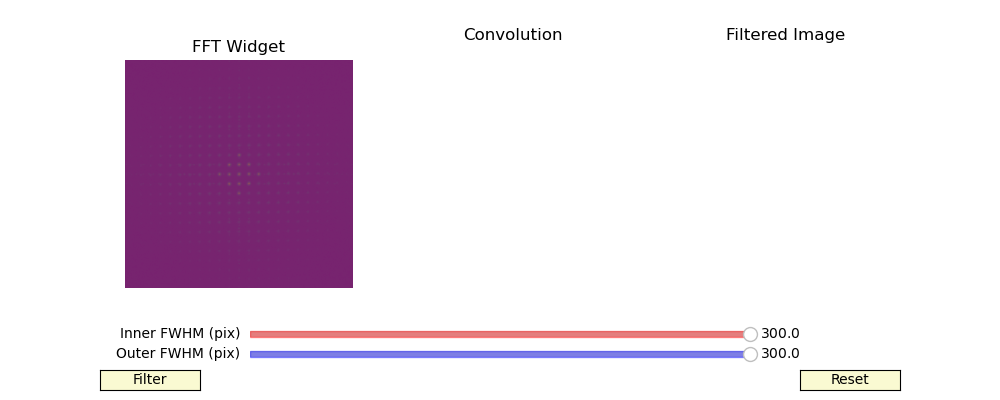

In [3]:
# Visually test which neg or pos value to use for gaussian fft filter
tml.visualise_dg_filter(image_resized, figsize=(10,4))


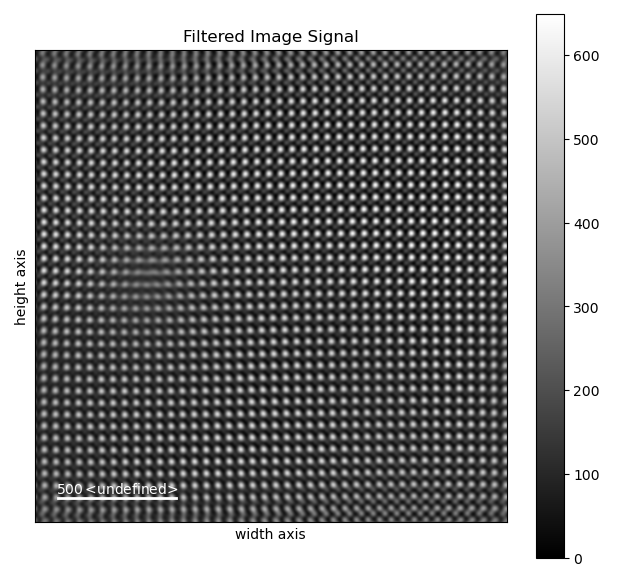

In [4]:
filtered_image = tml.double_gaussian_fft_filter(image_resized, 25, 107)
#filtered_image = tml.double_gaussian_fft_filter(image_resized, 146, 146)
# Shift all values to be positive
min_val = filtered_image.data.min()
if min_val < 0:
    filtered_image.data -= min_val
image = filtered_image

# Plot the filtered image
filtered_image.plot()

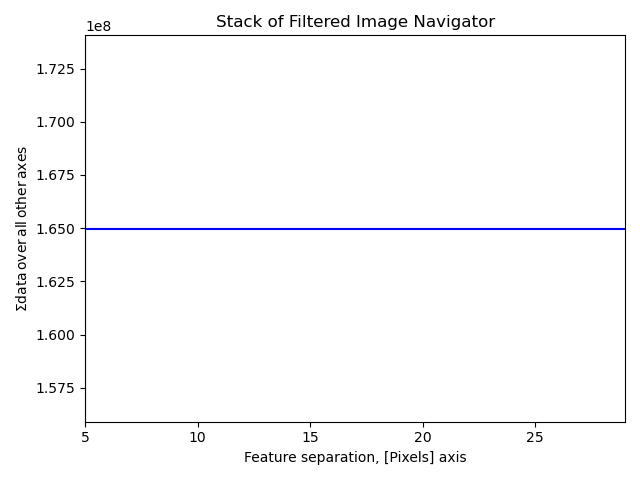

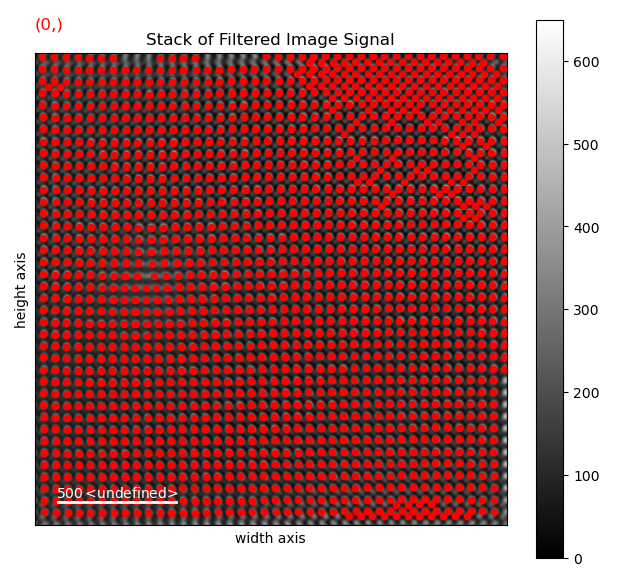

In [5]:
# Determine 

s_peaks = am.get_feature_separation(filtered_image, show_progressbar=False)
s_peaks.plot()


Center of mass:   0%|          | 0/1502 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/1502 [00:00<?, ?it/s]

Subtracting atoms:   0%|          | 0/1502 [00:00<?, ?it/s]

Subtracting atoms:   0%|          | 0/1502 [00:00<?, ?it/s]

Center of mass:   0%|          | 0/1423 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/1423 [00:00<?, ?it/s]

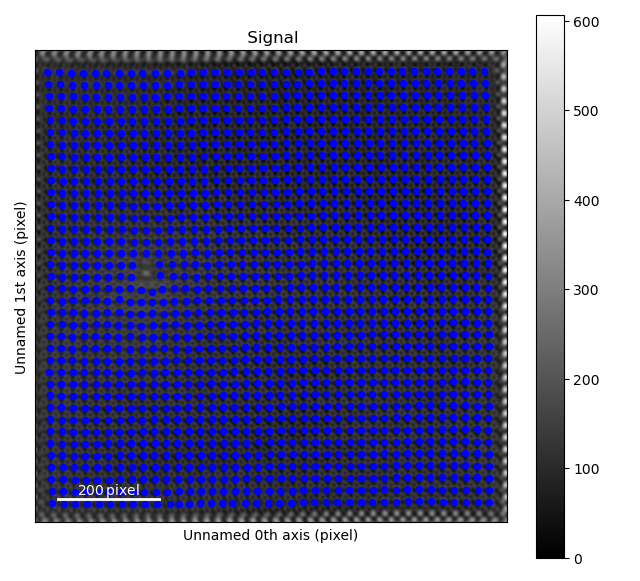

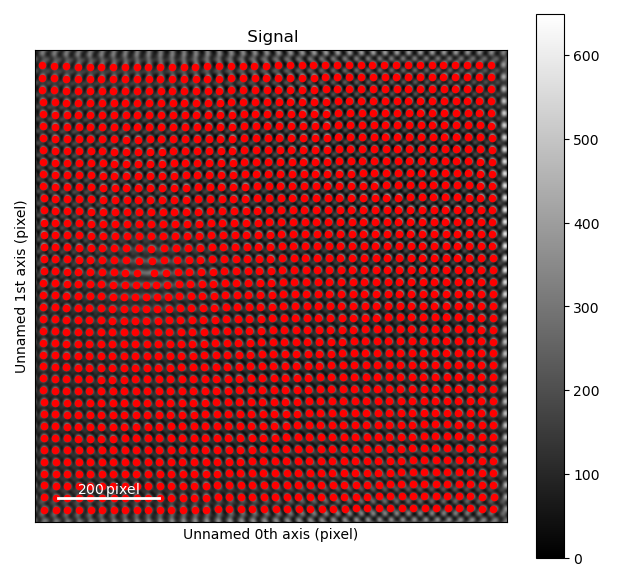

In [6]:
separation = 10
sublattice_A, image_noA = GetLatticeA(image, separation)
zone_axis_001 = sublattice_A.zones_axis_average_distances[3]
B_positions = sublattice_A.find_missing_atoms_from_zone_vector(zone_axis_001)
image_without_A = remove_atoms_from_image_using_2d_gaussian(sublattice_A.image, sublattice_A)
sublattice_B = am.Sublattice(B_positions, image_without_A, color='blue', fix_negative_values = True)
sublattice_B.construct_zone_axes()
sublattice_B.refine_atom_positions_using_center_of_mass()
sublattice_B.refine_atom_positions_using_2d_gaussian()
atom_lattice = am.Atom_Lattice(image=filtered_image.data, name='test', sublattice_list=[sublattice_A, sublattice_B])

sublattice_A.plot()
sublattice_B.plot()
plt.show()

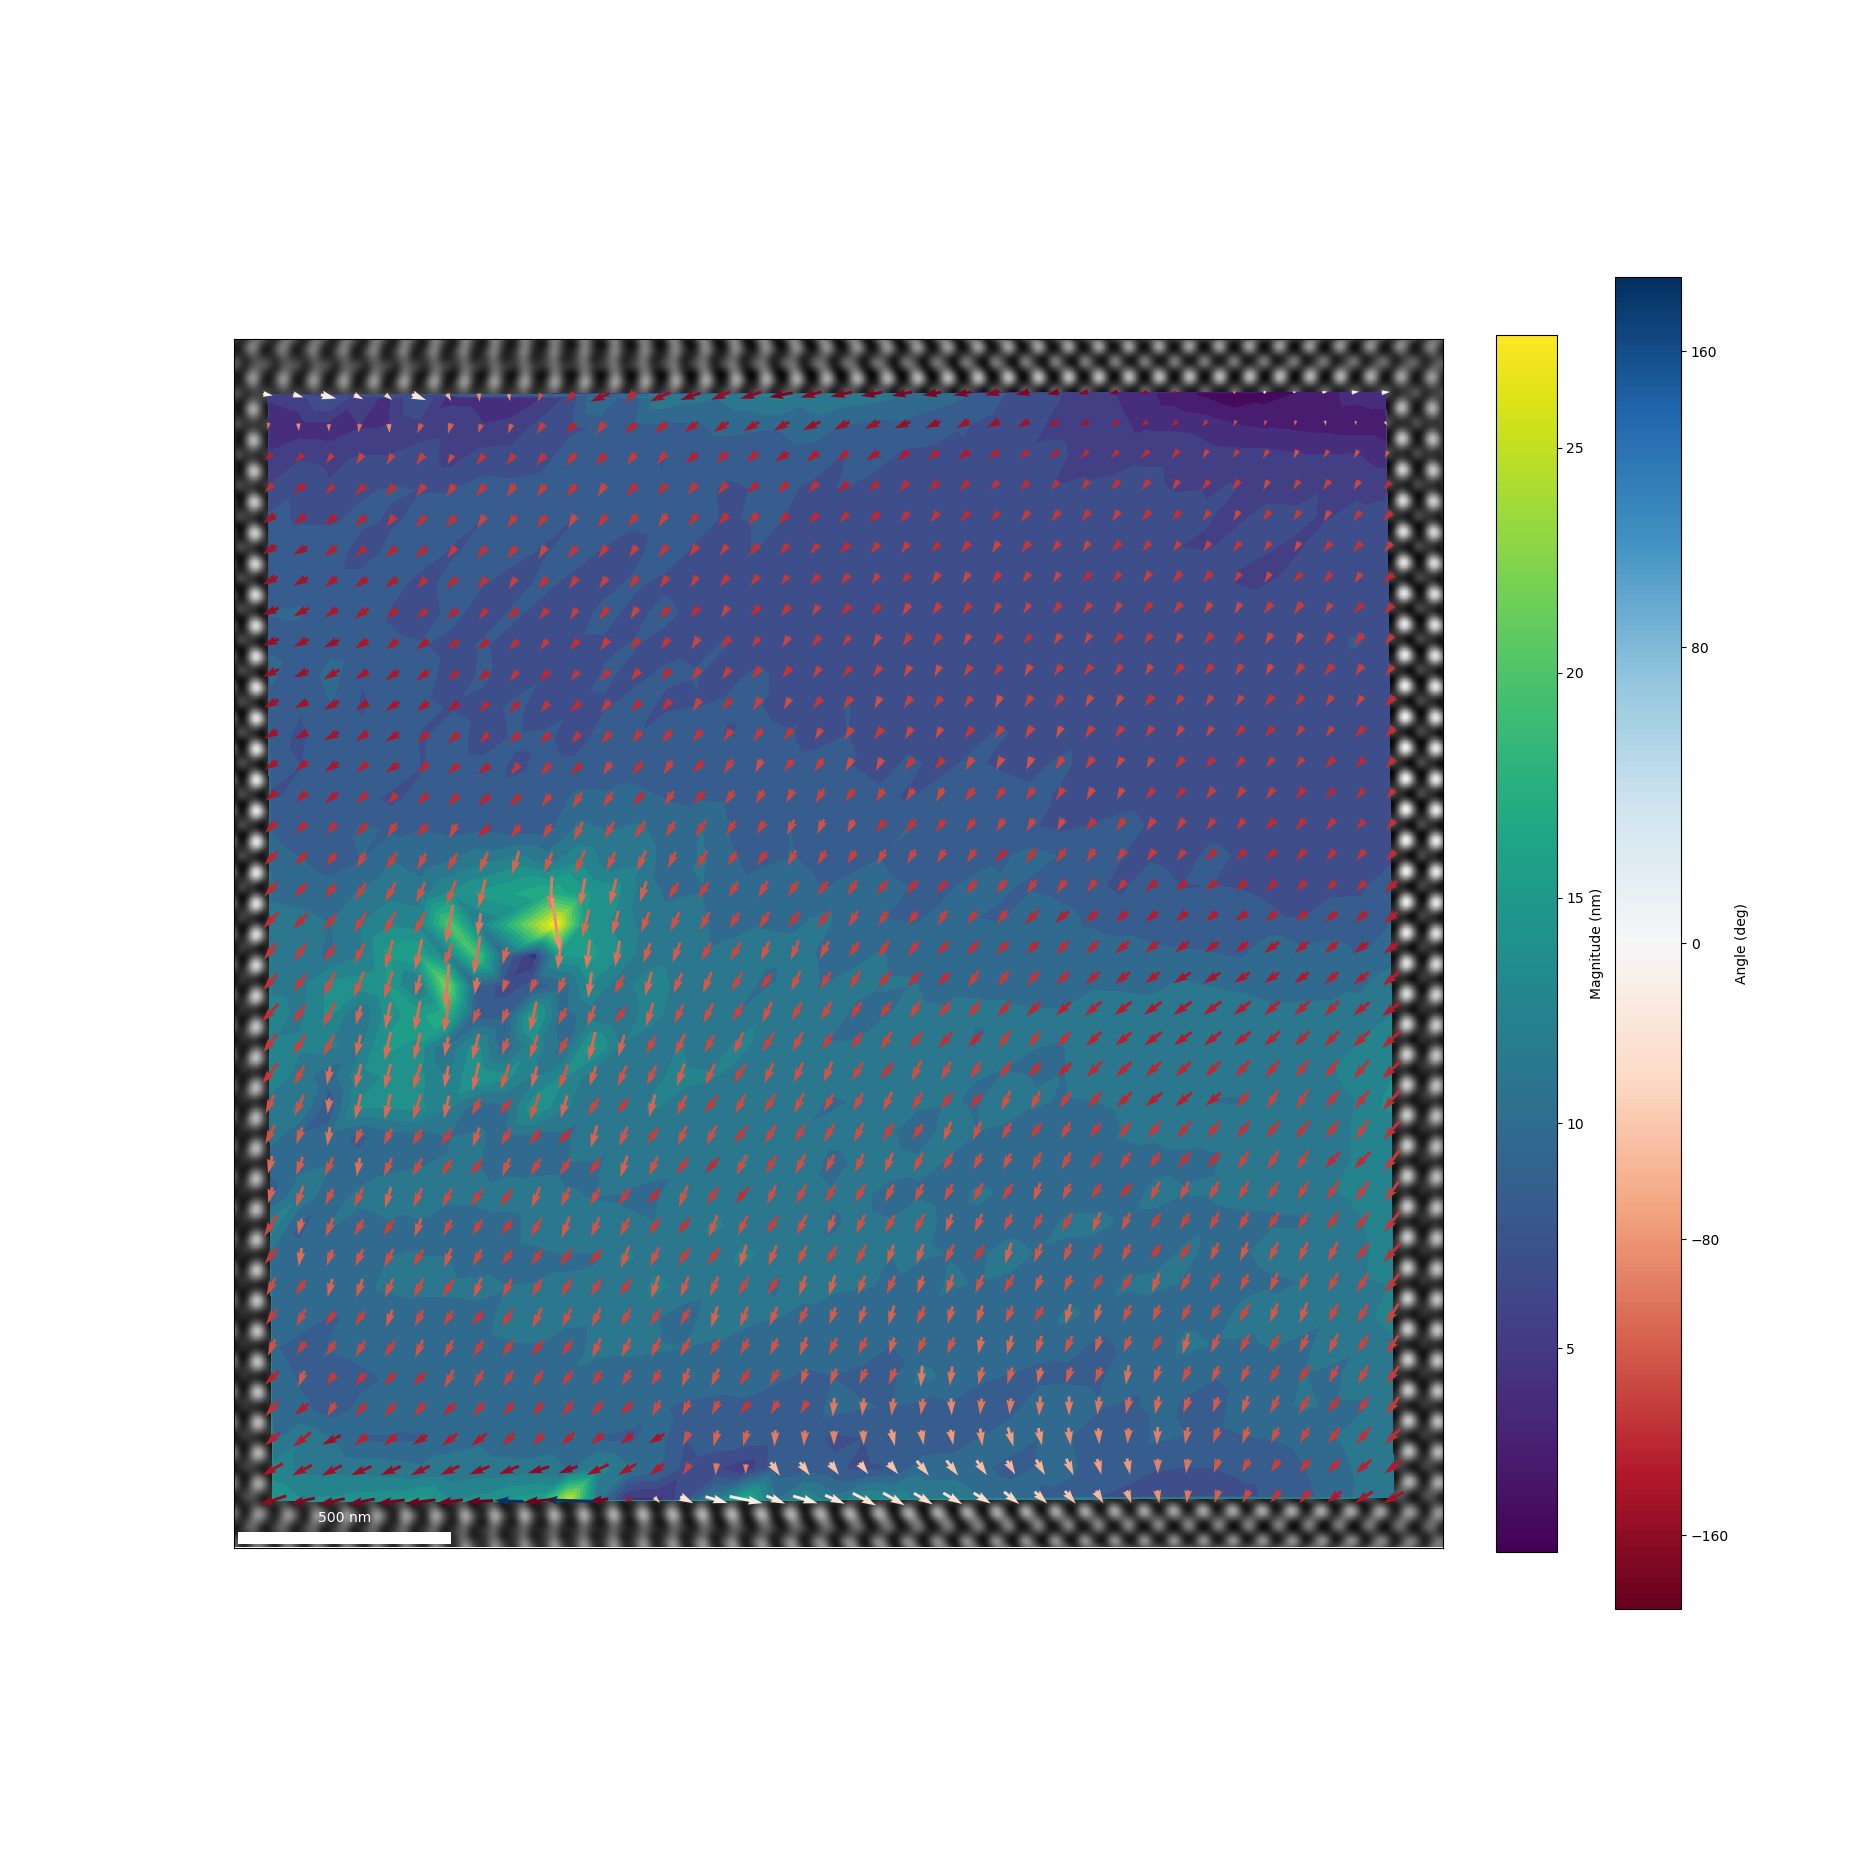

In [7]:
za0, za1 = sublattice_A.zones_axis_average_distances[0:2]
s_p = sublattice_A.get_polarization_from_second_sublattice(
    za0, za1, sublattice_B)

vector_list = s_p.metadata.vector_list
x, y = [i[0] for i in vector_list], [i[1] for i in vector_list]
u, v = [i[2] for i in vector_list], [i[3] for i in vector_list]
sampling, units =  0.05, 'nm'

ax = polarpy.plot_polarisation_maps(x, y, u, v, image=atom_lattice.image,
                          sampling=3.0321, units='nm', monitor_dpi= 50,
                          unit_vector=False, plot_style='contour_vector_map',
                          overlay=True, save=None, cmap='RdBu', vector_rep = 'angle',
                          scalebar=True, ticks = ticker.MaxNLocator(nbins=5), degrees = True)

plt.savefig(file[:-4] + "_plot1.png")





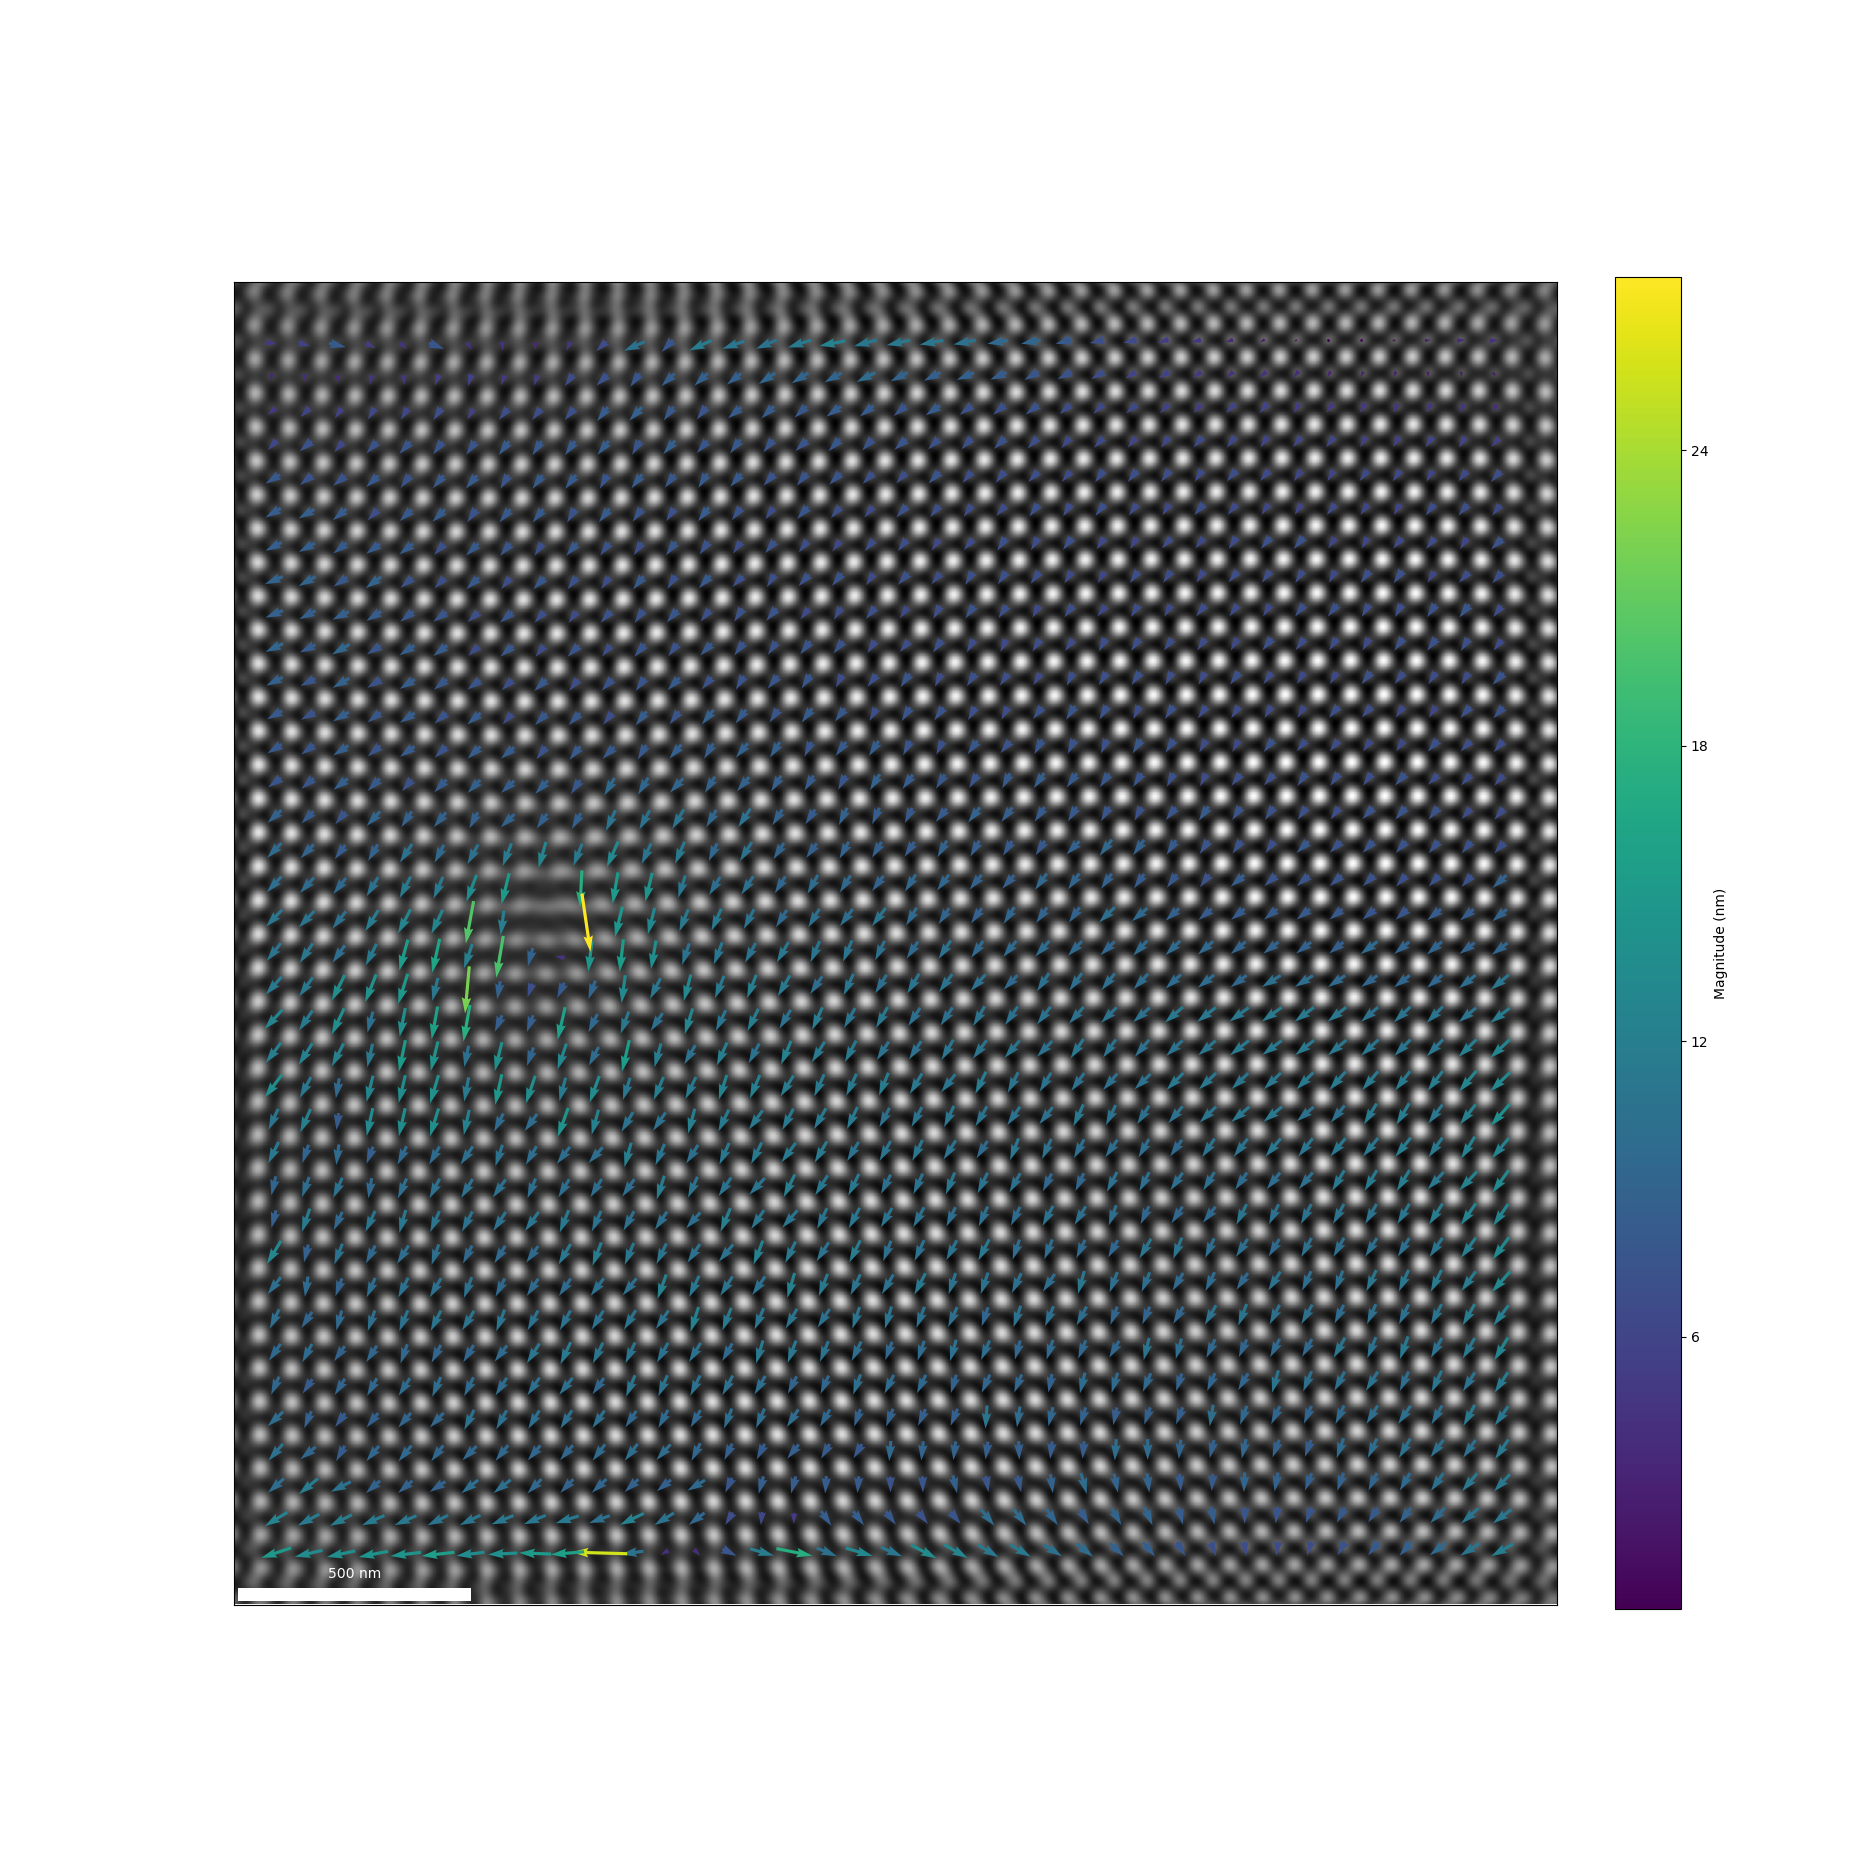

In [8]:
ax = polarpy.plot_polarisation_maps(x, y, u, v, image=atom_lattice.image,
                          sampling=3.0321, units='nm', monitor_dpi= 50,
                          unit_vector=False, plot_style='colormap',
                          overlay=True, save=None, scalebar=True, ticks = ticker.MaxNLocator(nbins=5), degrees = True)

plt.savefig(file[:-4] + "_plot2.png")
